In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

import surprise as sup

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# load population scores

In [2]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

bin_map = dict(zip(scores['bin_name'].values, scores['bin'].values))

scores.head()

scores.shape=(2431, 36)


,bin_name,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# Load expression data

In [3]:
fpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/expression_table/rna_table.parquet"
tdf = pd.read_parquet(fpath)
print(f"(raw) {tdf.shape=}")
print(f"(filtered) {tdf.shape=}")

expression_map = dict(zip(tdf['gene_name'].values, tdf['TPM'].values))

tdf.sample(5)

(raw) tdf.shape=(51883, 19)
(filtered) tdf.shape=(51883, 19)


,gene_id,transcript_id(s),length,effective_length,expected_count,TPM,FPKM,posterior_mean_count,posterior_standard_deviation_of_count,pme_TPM,pme_FPKM,TPM_ci_lower_bound,TPM_ci_upper_bound,TPM_coefficient_of_quartile_variation,FPKM_ci_lower_bound,FPKM_ci_upper_bound,FPKM_coefficient_of_quartile_variation,ens_gene_id,gene_name
22115,ENSMUSG00000078920.3,"ENSMUST00000046704.6,ENSMUST00000109202.2,ENSM...",1316.20,1064.44,0.00,0.00,0.00,0.00,0.00,0.44,0.35,0.081638,0.896496,0.335335,0.062248,0.699599,0.335298,ENSMUSG00000078920,Ifi47
8689,ENSMUSG00000031984.8,"ENSMUST00000034465.8,ENSMUST00000211971.1,ENSM...",2318.95,2067.19,1893.00,67.82,50.58,1893.00,0.00,64.30,50.27,61.408900,67.233000,0.015509,48.043600,52.588300,0.015545,ENSMUSG00000031984,2810004N23Rik
35902,ENSMUSG00000101013.1,ENSMUST00000190567.1,5410.00,5158.24,28.89,0.41,0.31,28.37,6.19,0.40,0.31,0.188216,0.626746,0.188826,0.147831,0.490876,0.188633,ENSMUSG00000101013,A630072M18Rik
47504,ENSMUSG00000113601.1,ENSMUST00000222614.1,1310.00,1058.24,4.00,0.28,0.21,4.00,0.00,0.33,0.26,0.080157,0.623535,0.300451,0.062928,0.488089,0.300593,ENSMUSG00000113601,Gm48735
24857,ENSMUSG00000083287.4,ENSMUST00000121574.1,684.00,432.25,19.51,3.34,2.49,21.25,7.22,3.61,2.82,1.164660,6.351980,0.265904,0.912482,4.969470,0.266008,ENSMUSG00000083287,Idi1-ps1


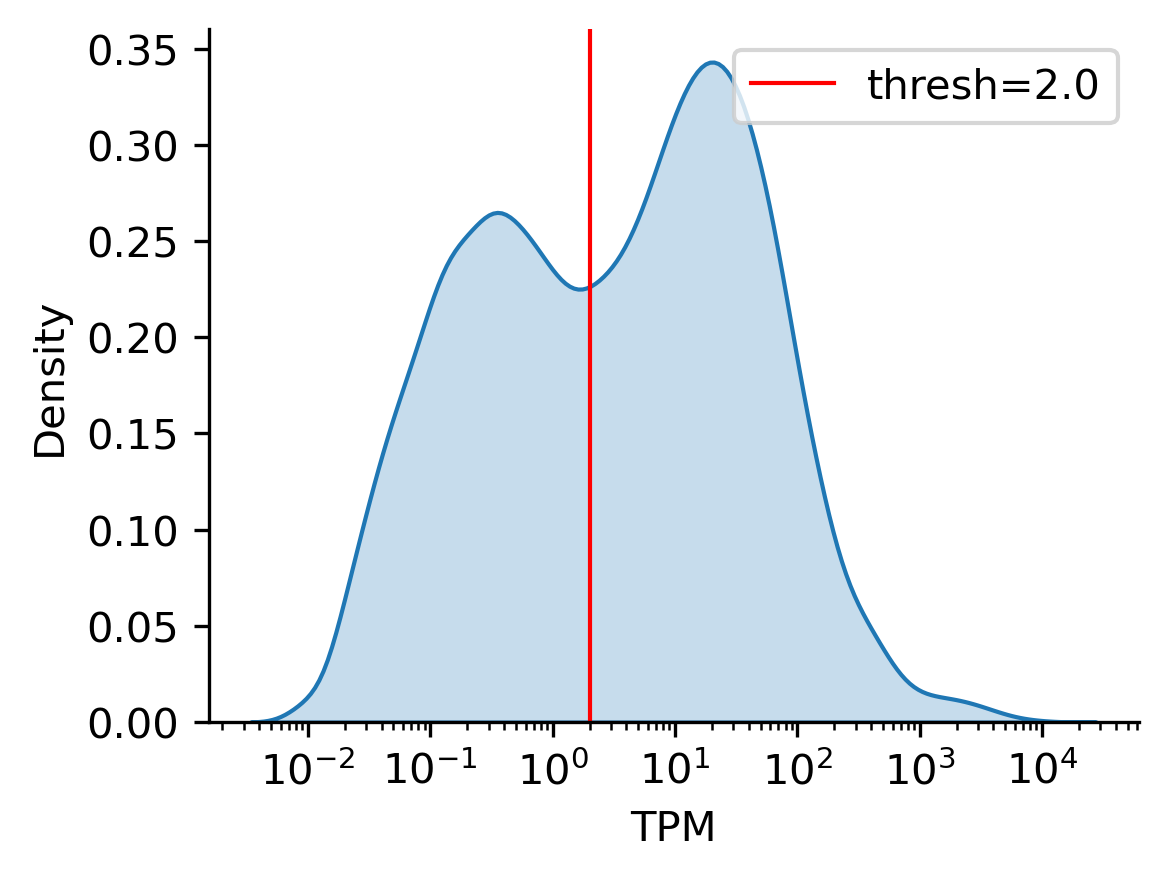

In [4]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4 ,3

sns.kdeplot(
    data=tdf[tdf['TPM'] > 0], 
    x='TPM',
    fill=True,
    log_scale=True,
)

thresh = 2.0
plt.axvline(x=2.0, c='r', lw=1, label=f"{thresh=}")
plt.legend(loc='upper right')
sns.despine()

# load population gene mapping

In [5]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)

""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column].fillna(0.0), core_threshold_quantile)
df['is_core'] = df[score_column] > threshold

print(df['is_core'].value_counts())

"""ADD the gene order and expression """
df['bin'] = df['bin_name'].map(bin_map)
df['expression'] = df['gene_name'].map(expression_map)

print(f"{df.shape=}")
df.head()

is_core
False    3704772
True     1234495
Name: count, dtype: int64
df.shape=(4939267, 14)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,bin,expression
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False,1394.0,4.12
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False,2436.0,4.55
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,True,665.0,87.94
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False,1659.0,NaN
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False,2289.0,23.16


# Identify the core tf clusters

In [10]:
tf = 1
d = 2
t = 2.0

"""criteria:
    1. one TF
    2. d protien-coding genes in the core with expression over t
"""

core = df.copy()
print(f"(raw) {core.shape=}")
core = core[core['expression'].notna()]
core = core[core['gene_biotype'] == 'protein_coding']
core['is_expressed'] = core['expression'] > t

core = core.groupby('read_name').agg(
    tf = ('is_tf', 'sum'),
    core = ('is_core', 'sum'),
    expressed = ('is_expressed', 'sum'),
).reset_index()

print(f"(grouped) {core.shape=}")

core = core[core['tf'] >= tf]
core = core[core['core'] >= d]
core = core[core['expressed'] >= t]

print(f"(filtered) {core.shape=}")

core.head()

(raw) core.shape=(4939267, 14)
(grouped) core.shape=(2021658, 4)
(filtered) core.shape=(38582, 4)


,read_name,tf,core,expressed
28,0000c863-d9dd-4589-8307-614a9f5db5b1,1,2,2
90,0003060b-d552-48f5-a116-6219ff00b425,1,2,4
166,00055dd1-0900-4c4c-986f-2d31b8093830,1,2,2
180,00059de3-2ef6-47be-b133-27b1dbb5d212,3,2,4
217,0006c00f-8c61-4d94-946b-8b056e4a292c,1,3,3


# Summarize

In [20]:
H = df[df['read_name'].isin(core['read_name'].values)].copy()

print("-" * 30)
print("Top 10 Gene Counts")
print("-" * 30)
print(H['gene_name'].value_counts().head(10).to_markdown(numalign="left", stralign="left"))

print("\n")
print("-" * 30)
print("Top 10 Gene Counts (Transcription Factors)")
print("-" * 30)
print(H[H['is_tf']]['gene_name'].value_counts().head(10).to_markdown(numalign="left", stralign="left"))

print("\n")
print("-" * 30)
print("Top 10 Gene Counts (Core Genes)")
print("-" * 30)
print(H[H['is_core']]['gene_name'].value_counts().head(10).to_markdown(numalign="left", stralign="left"))

------------------------------
Top 10 Gene Counts
------------------------------
| gene_name   | count   |
|:------------|:--------|
| Chl1        | 989     |
| Cers5       | 581     |
| Zfhx3       | 487     |
| Msi2        | 457     |
| Bach2       | 416     |
| Sox5        | 407     |
| Nf1         | 379     |
| Tcf12       | 370     |
| Rbfox2      | 347     |
| Ubqln1      | 329     |


------------------------------
Top 10 Gene Counts (Transcription Factors)
------------------------------
| gene_name   | count   |
|:------------|:--------|
| Cers5       | 581     |
| Zfhx3       | 487     |
| Msi2        | 457     |
| Bach2       | 416     |
| Sox5        | 407     |
| Nf1         | 379     |
| Tcf12       | 370     |
| Rbfox2      | 347     |
| Gli2        | 278     |
| Hivep3      | 270     |


------------------------------
Top 10 Gene Counts (Core Genes)
------------------------------
| gene_name   | count   |
|:------------|:--------|
| Cers5       | 581     |
| Msi2        

# Visualize

In [12]:
H = df[df['read_name'].isin(core['read_name'].values)].copy()
print(f"{H.shape=}")

H = H.sort_values(by='read_name')

H.head()

H.shape=(207829, 14)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,bin,expression
3198635,Rbks,protein_coding,0000c863-d9dd-4589-8307-614a9f5db5b1,chr5:31,False,0.697998,0.879673,1.214379,0.522783,1.267397,0.474480,True,726.0,4.03
3870433,Kcnc2,protein_coding,0000c863-d9dd-4589-8307-614a9f5db5b1,chr10:112,False,0.605806,0.391525,0.242026,0.688576,1.108816,0.517091,True,1510.0,0.00
3728774,Rptor,protein_coding,0000c863-d9dd-4589-8307-614a9f5db5b1,chr11:119,False,0.938993,1.465949,1.429246,1.152460,0.598882,0.314918,False,1648.0,34.71
631908,Plb1,protein_coding,0000c863-d9dd-4589-8307-614a9f5db5b1,chr5:32,False,0.699282,0.739847,1.130352,0.538798,0.636969,0.356283,False,727.0,0.16
3504200,Zmat4,protein_coding,0000c863-d9dd-4589-8307-614a9f5db5b1,chr8:24,True,0.564318,0.803981,0.593167,0.762261,0.235434,0.234176,False,1166.0,0.26


In [8]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# core vs expression

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

print(f"{pdf.shape=}")
print(f"{pdf['is_core'].value_counts()}")
print()
print(f"{pdf['is_core'].value_counts(normalize=True)}")

# Perform t-test
core_expression = pdf[pdf['is_core'] == True]['expression'].fillna(0.0)
non_core_expression = pdf[pdf['is_core'] == False]['expression'].fillna(0.0)
t_stat, p_value = scipy.stats.ttest_ind(core_expression, non_core_expression)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.3f}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3.5

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    palette=['lightgrey', 'red'],
    linecolor='k',
    width=0.5,
    legend=False,
)

plt.ylabel('expression (log TPM)')
plt.xlabel('')
plt.gca().set_xticklabels(['non-core', 'core'])

sns.despine()
pdf.head()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=pdf,
    x='ATACSeq_1',
    y='expression',
    ec='none',
    palette='hot',
    hue='global_hge_logexp_RNA_weighted',
    s=5,
    legend=False,
)

plt.yscale('log')

plt.ylabel('TPM (log)')
plt.xlabel('ATAC-seq')
sns.despine()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'is_core', ]].drop_duplicates()
pdf['expression'] = np.log1p(pdf['gene_name'].map(expression_map))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 1, 2

sns.boxplot(
    data=pdf,
    x='is_core',
    y='expression',
    hue='is_core',
    showfliers=False,
    width=0.5,
)

pdf.head()

In [ ]:
pdf = df.copy()

pdf = pdf[['gene_name', 'ATACSeq_1', 'CTCF', 'H3K27ac', 'is_core', 'global_hge_logexp_RNA_weighted']].drop_duplicates()
pdf['expression'] = pdf['gene_name'].map(expression_map)
pdf = pdf[pdf['expression'] > 0]
pdf = pdf[pdf['ATACSeq_1'] > 0]

pdf = pdf.sort_values(by='global_hge_logexp_RNA_weighted')

sns.histplot(
    data=pdf,
    kde=True,
    x='ATACSeq_1',
    y='expression',
    bins=101,
    log_scale=(True, False),
    palette='hot',
    hue='is_core',
)